# Image Processing SoSe 22 - Assignment - 02

### Deadline is 05.05.2022 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.

# Exercise 1 - 4 Points
Implement the `rgb_to_hsv` and `hsv_to_rgb` functions. Don't use any color conversion functions from a library.

In [40]:
def rgb_to_hsv(x):
    """
    Converts the numpy array `x` from RGB to the HSV.
    """
    for i in x:
        for j in i:
            r,g,b = j
            rgbmax = max(r,g,b)
            rgbmin = min(r,g,b)
            h = 0
            s = 0
            v = rgbmax
            if rgbmax!=rgbmin:
                if rgbmax == r:
                    h = 60*(((g-b)/rgbmax-rgbmin)%6)
                elif rgbmax == g:
                    h = 60*(2+((b-r)/rgbmax-rgbmin))
                elif rgbmax == b:
                    h = 60*(4+((r-g)/rgbmax-rgbmin))
            if h < 0:
                h = h+360
            if rgbmax != 0:
                s = (rgbmax-rgbmin)/rgbmax
            j[0]=h
            j[1]=s
            j[2]=v
    return x

In [41]:
def hsv_to_rgb(x):
    """
    Converts the numpy array `x` from HSV to the RGB.
    """
    for i in x:
        for j in i:
            C = j[2]*j[1]
            X = C * (1- abs(((j[0]/60) % 2)-1))
            m = j[2]-C
            if 0 <= j[0] < 60 or j[0] == 360:
                j[0]=C + m
                j[1]=X + m
                j[2]=m
            if 60 <= j[0] < 120:
                j[0]=X + m
                j[1]=C + m
                j[2]=m
            if 120 <= j[0] < 180:
                j[0]=m
                j[1]=C + m
                j[2]=X + m
            if 180 <= j[0] < 240:
                j[0]=m
                j[1]=X + m
                j[2]=C + m
            if 240 <= j[0] < 300:
                j[0]=X + m
                j[1]=m
                j[2]=C + m
            if 300 <= j[0] < 360:
                j[0]=C + m
                j[1]=m
                j[2]=X + m
    return x

Plot the saturation of the astronaut image (see last assignment)

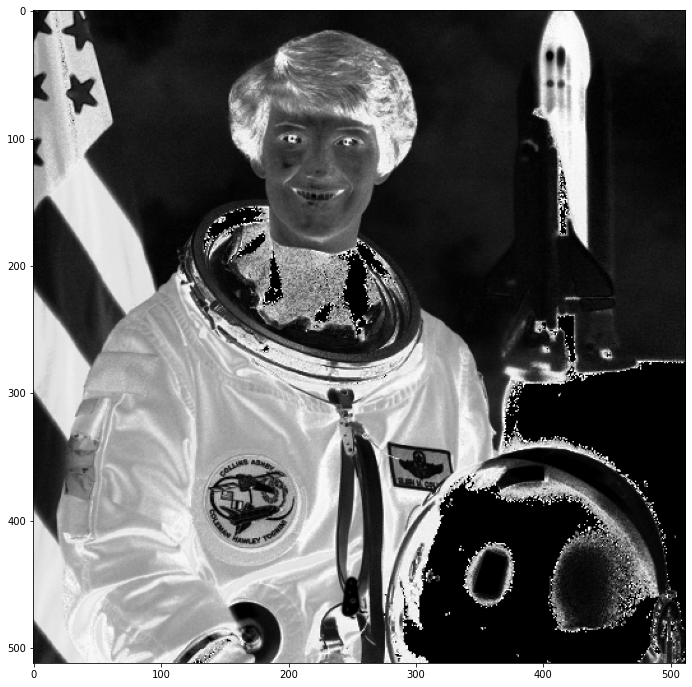

In [42]:
# display the plots inside the notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage.data import astronaut
import pylab
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

img = astronaut() / 255.
img_as_hsv = rgb_to_hsv(img)
img_s = np.zeros(img_as_hsv.shape)
img_s[:,:,:] = img_as_hsv[:,:,:]
for d in img_s:
    for e in d:
        e[0] = e[1]
        e[2] = e[1]
plt.imshow(img_s)
plt.show()

Increase the saturation by a factor of 2, convert it back to RGB and plot the result.

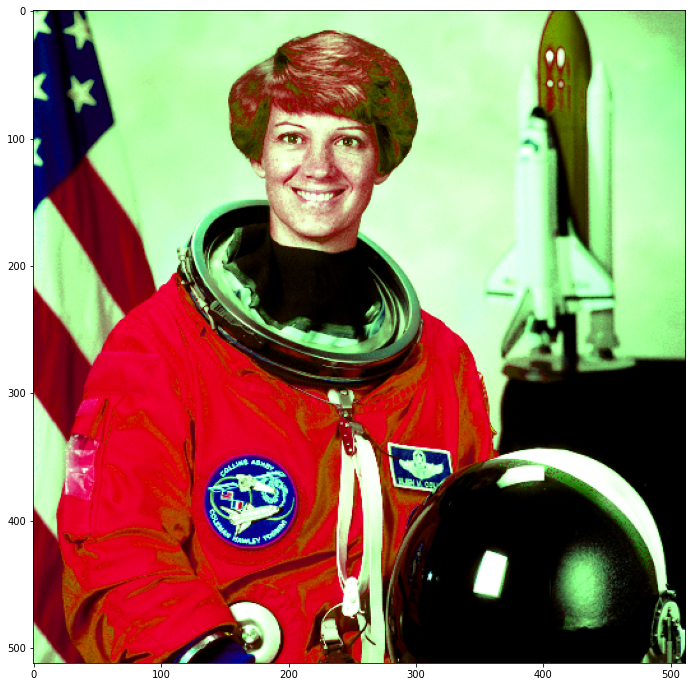

In [43]:
for d in img:
    for e in d:
        e[1] = min(1,e[1]*2)
img_as_rgb = hsv_to_rgb(img_as_hsv)
for d in img_as_rgb:
    for e in d:
        e[1] = min(1,e[1]*2)
plt.imshow(img_as_rgb)
plt.show()

# Exercise 2 - 6 Points

Implement affine transformation with [linear interpolation].
Implement the functions `affine_transformation` and `bilinear_interpolation`. Apply some affine transformation of your choice and smooth the output using your bilinear interpolation.

The [skimage](http://scikit-image.org/) library comes with multiple useful test images.  Let's start with an image of an astronaut. 

In [44]:
from skimage.data import astronaut
from skimage.color import rgb2gray

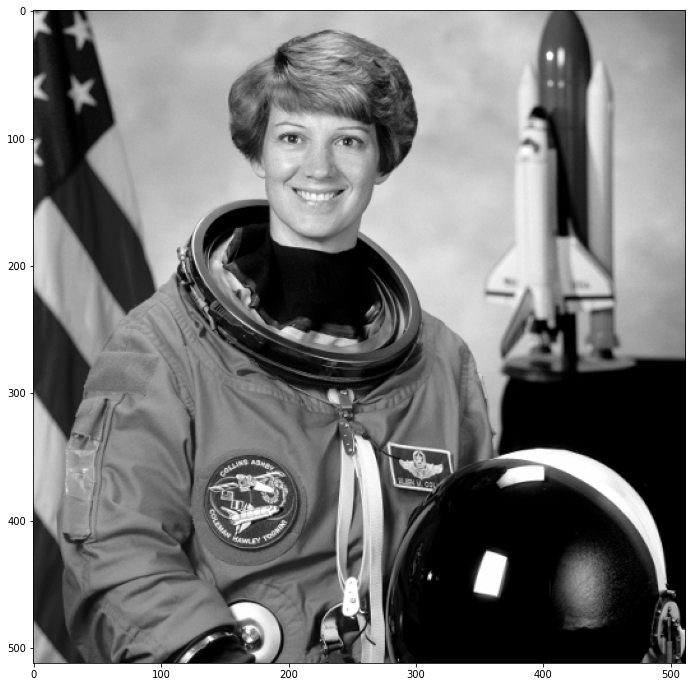

In [45]:
# We use a gray image. All the algorithms should work with color images too.
img = rgb2gray(astronaut() / 255.)
plt.imshow(img, cmap='gray')
plt.show()

In [46]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if y + 1 < image.shape[1] and y - 1 > 0:
                derived_image[x,y] = (image[x, y + 1] - image[x, y - 1]) / 2.0
    return derived_image

def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if x + 1 < image.shape[1] and x - 1 > 0:
                derived_image[x,y] = (image[x + 1, y] - image[x - 1, y]) / 2.0
    return derived_image

In [47]:
dx_img = derive_x(img)
dy_img = derive_y(img)

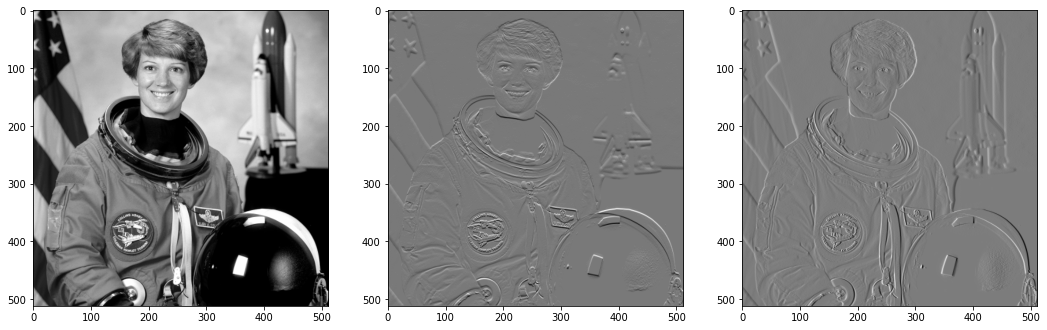

In [48]:
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

Here are some sample affine transformations to be used later on

In [49]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])

In [50]:
T_shear = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

In [51]:
# you can use this function to invert the matricies
np.linalg.inv(T_scale)

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.33333333, 0.        ],
       [0.        , 0.        , 1.        ]])

In [52]:
def affine_transformation(img, matrix):
    derived_image = np.zeros_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            v = np.matmul(np.linalg.inv(matrix),np.array([x,y,1]))
            x_ori = v[0]
            y_ori = v[1]
            derived_image[x,y] = bilinear_interpolation(img,x_ori,y_ori)
    return derived_image

In [53]:
import math
def bilinear_interpolation(img,x,y):
    if x > img.shape[0]-1 or x <0 or y > img.shape[1]-1 or y < 0:
        return 0
    else:
        x1 = math.floor(x)
        x2 = math.ceil(x)
        y1 = math.floor(y)
        y2 = math.ceil(y)
        q11 = img[x1,y1]
        q12 = img[x1,y2]
        q21 = img[x2,y1]
        q22 = img[x2,y2]
        if x1 == x2:
            r1 = q11
            r2 = q21
        else:
            r1 = ((x2-x)/(x2-x1))*q11 + ((x-x1)/(x2-x1))*q21
            r2 = ((x2-x)/(x2-x1))*q12 + ((x-x1)/(x2-x1))*q22
        if y1 == y2:
            p = r1
        else:
            p = ((y2-y)/(y2-y1))*r1 + ((y-y1)/(y2-y1))*r2
        return p

In [54]:
img_scale = affine_transformation(img, T_scale)
img_shear = affine_transformation(img, T_shear)

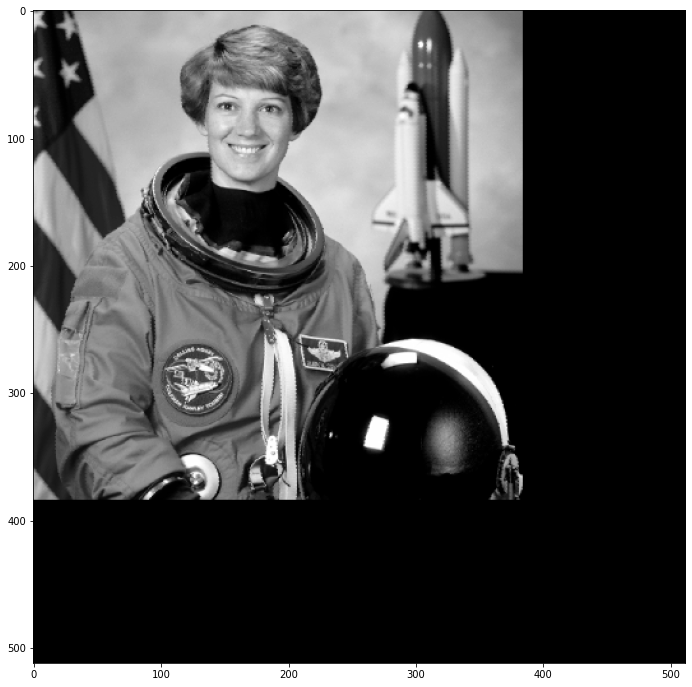

In [55]:
plt.imshow(img_scale, cmap='gray')
plt.show()

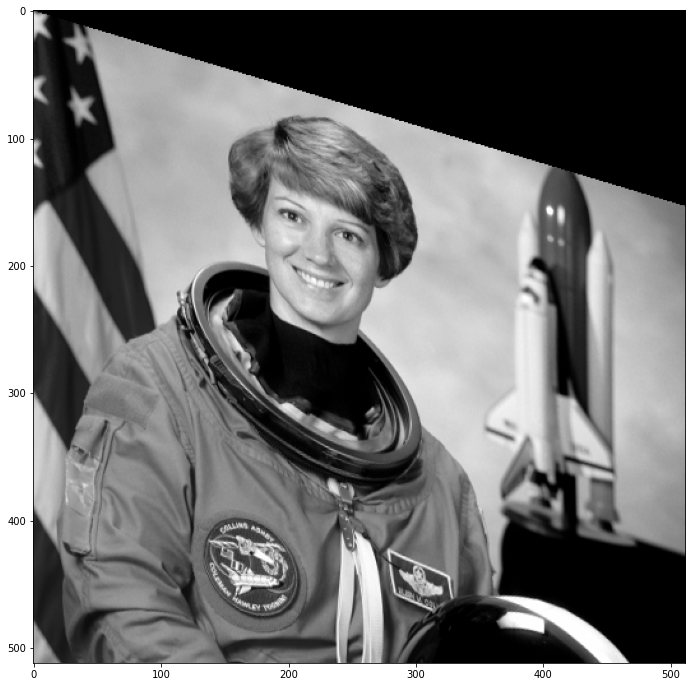

In [56]:
plt.imshow(img_shear, cmap='gray')
plt.show()